<a href="https://colab.research.google.com/github/omaskii/Portfolio_Projects_Python/blob/main/Computer_Vision_Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solomon Akatakpo (Ph.D.)

# Project 8: Plant Seedlings Classification

## Problem Statement

### Context


In recent years, the agricultural sector has faced a pressing need for modernization. Despite technological advancements, the labor-intensive task of identifying and categorizing various plants and weeds still consumes a significant amount of time and effort. This trillion-dollar industry holds immense potential for transformation through technological innovation, particularly leveraging Artificial Intelligence (AI) and Deep Learning.

AI has the power to revolutionize plant recognition and seedling identification, significantly reducing the time and energy required for these tasks. In fact, AI can outperform manual labor in terms of efficiency and accuracy. This breakthrough has the potential to lead to higher crop yields, while simultaneously liberating human resources for more strategic agricultural decision-making.

Furthermore, the adoption of AI in agriculture promises to promote sustainable environmental practices. By streamlining and optimizing processes, AI can contribute to more eco-friendly farming methods. In essence, the integration of AI and Deep Learning stands to benefit both agricultural productivity and environmental sustainability, marking a pivotal moment in the industry's evolution.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## **Please read the instructions carefully before starting the project.**

This is a commented Python Notebook file in which all the instructions and tasks to be performed are mentioned.

* Blanks '_______' are provided in the notebook that need to be filled with an appropriate code to get the correct result

* With every '_______' blank, there is a comment that briefly describes what needs to be filled in the blank space

* Identify the task to be performed correctly and only then proceed to write the required code

* Fill the code wherever asked by the commented lines like "# write your code here" or "# complete the code"

* Running incomplete code may throw an error

* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors

* Add the results/observations derived from the analysis in the presentation and submit the same in .pdf format

## Importing necessary libraries

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/Data_Science/Into_Computer_Vision/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/Data_Science/Into_Computer_Vision/Labels.csv')

## Data Overview



```
# This is formatted as code
```

### Overview of the dataset

In [8]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


* There are 4750 RGB iages of shape 128 x 128 x 3, each image having 3 channels


## Exploratory Data Analysis

### Plotting random images from each of the class

In [9]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

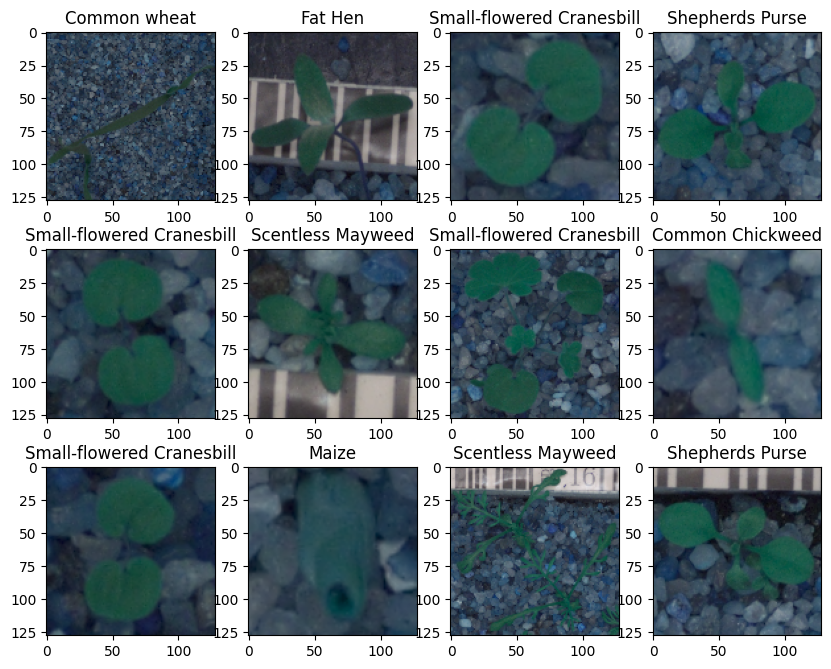

In [10]:
plot_images(images,labels)   # plot the images with their labels

### Checking the distribution of the target variable

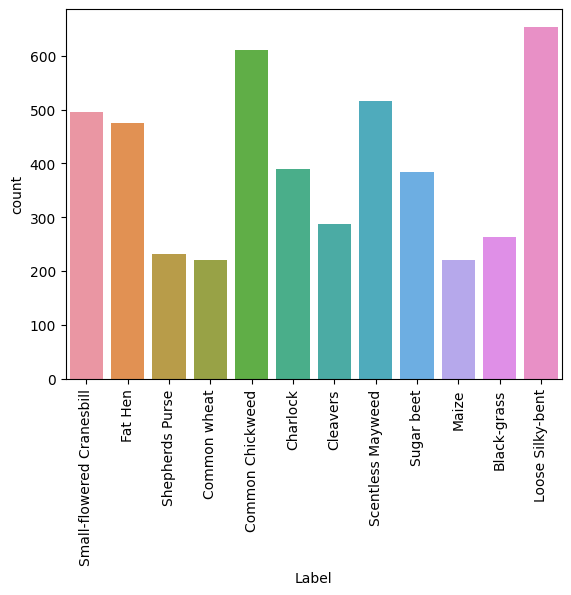

In [11]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')
plt.show()

* As we cvan see from the above plot, the dataset is quite inbalanced.
* There are more images in the Loose Silky-bent category, Common Chickweed and Scentless Mayweed categories (~ 500 - ~ 670 images) and less images in Maize and Common Wheat categories (~200 images)

## Data Pre-Processing

### Converting the BGR images to RGB images.

In [12]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)


### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [13]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

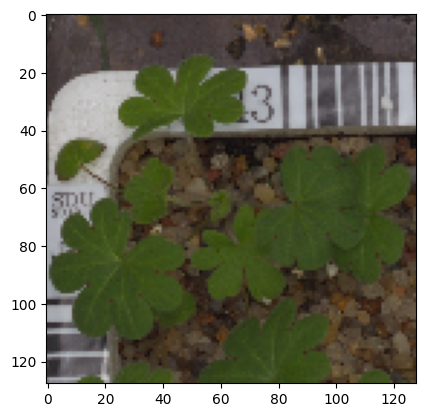

In [14]:
plt.imshow(images[3])

**Image after resizing**

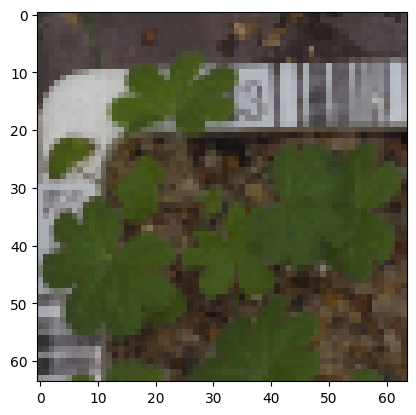

In [15]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels, test_size=0.1, random_state=42,stratify=labels)   # To split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                       # To split the data with test_size as 0.1

In [17]:
# To check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encoding the target labels

In [18]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()                              # Intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)        # Fit and transform y_train
y_val_encoded=enc.transform(y_val)                  # Transform y_val
y_test_encoded=enc.transform(y_test)                # Transform y_test

In [19]:
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape   # To check the shape of train, validation and test data

((3847, 12), (428, 12), (475, 12))

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [20]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [21]:
# Clearing backend
backend.clear_session()

In [22]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [23]:
# Intializing a sequential model
model1 = Sequential()                            # Intialize a sequential model

# To add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# To add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# To create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# To flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# To add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# To add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Complete the code to use the Adam Optimizer
opt=Adam()
# Complete the code to Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Complete the code to generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

<b> Fitting the model on the train data

In [38]:
# To fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 1s - loss: 0.4717 - accuracy: 0.8102 - val_loss: 1.6982 - val_accuracy: 0.7383 - 1s/epoch - 10ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4970 - accuracy: 0.7985 - val_loss: 1.8143 - val_accuracy: 0.7313 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4954 - accuracy: 0.8032 - val_loss: 2.1358 - val_accuracy: 0.7243 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 0.5031 - accuracy: 0.8053 - val_loss: 1.8908 - val_accuracy: 0.7196 - 1s/epoch - 9ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4753 - accuracy: 0.8082 - val_loss: 1.6986 - val_accuracy: 0.7360 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 0.4782 - accuracy: 0.8082 - val_loss: 1.9876 - val_accuracy: 0.7336 - 1s/epoch - 10ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4949 - accuracy: 0.8050 - val_loss: 1.9558 - val_accuracy: 0.7500 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4879 - accuracy: 0.8087 - val_loss: 1.9975 - val_accuracy: 0.7407 - 1s/epoch - 10ms/step
Epoch 9/30
121/121 

**Model Evaluation**

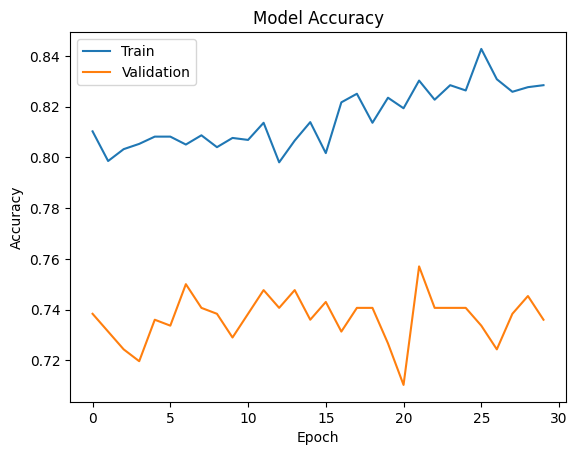

In [44]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The training accuracy was good but the validation accuracy was not significantly lower as the difference is ~ 10%
* There is a slight case of over fit

**Evaluate the model on test data**

In [43]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)   # To evaluate the model on test data

15/15 - 1s - loss: 2.0523 - accuracy: 0.7263 - 893ms/epoch - 60ms/step


**Plotting the Confusion Matrix**

In [45]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)

15/15 [==============================] - 0s 5ms/step


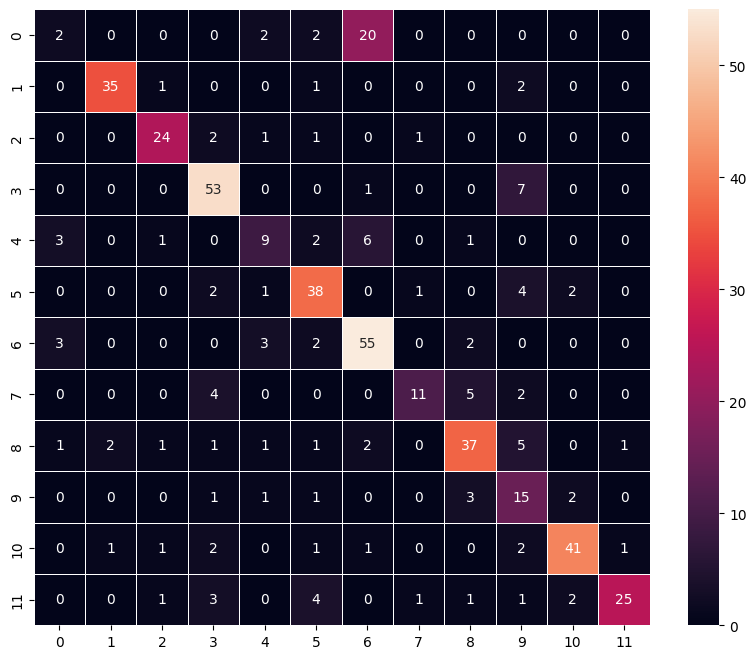

In [46]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Plotting Classification Report**

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))


              precision    recall  f1-score   support

           0       0.22      0.08      0.11        26
           1       0.92      0.90      0.91        39
           2       0.83      0.83      0.83        29
           3       0.78      0.87      0.82        61
           4       0.50      0.41      0.45        22
           5       0.72      0.79      0.75        48
           6       0.65      0.85      0.73        65
           7       0.79      0.50      0.61        22
           8       0.76      0.71      0.73        52
           9       0.39      0.65      0.49        23
          10       0.87      0.82      0.85        50
          11       0.93      0.66      0.77        38

    accuracy                           0.73       475
   macro avg       0.70      0.67      0.67       475
weighted avg       0.73      0.73      0.72       475



* Some of the classes are not predicted correctly
* In comparison to the rest, class 1, 4 and 9 are misclassified
* The other classes are well classified

## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [50]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


### **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember, **data augmentation should not be used in the validation/test data set**.

In [51]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [54]:
from tensorflow.keras.layers import BatchNormalization

# Initializing a sequential model
model2 = Sequential()

# Adding the first convolutional layer with 64 filters, kernel size 3x3, 'same' padding, and ReLU activation
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling layer after the first convolutional layer
model2.add(MaxPooling2D((2, 2), padding='same'))

# Adding the second convolutional layer with 32 filters, kernel size 3x3, 'same' padding, and ReLU activation
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))

# Adding max pooling layer after the second convolutional layer
model2.add(MaxPooling2D((2, 2), padding='same'))

# Adding BatchNormalization layer
model2.add(BatchNormalization())

# Flattening the output of the convolutional layer after max pooling
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons and ReLU activation
model2.add(Dense(16, activation='relu'))

# Adding dropout with dropout_rate=0.3
model2.add(Dropout(0.3))

# Adding the output layer with 12 neurons and softmax activation for multi-class classification
model2.add(Dense(12, activation='softmax'))

# Initializing Adam Optimizer
opt = Adam()

# Compiling the model with categorical cross-entropy as the loss function
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                      

<b> Fitting the model on the train data

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Fill mode for newly created pixels
)

# Fit the model using training data and validation data
history = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                         batch_size=batch_size,
                                         shuffle=False),
                     epochs=epochs,
                     steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                     validation_data=(X_val_normalized, y_val_encoded),
                     verbose=1,
                     callbacks=[learning_rate_reduction])



Epoch 1/30
60/60 [==============================] - 10s 125ms/step - loss: 2.4287 - accuracy: 0.1375 - val_loss: 2.4552 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 86ms/step - loss: 2.1718 - accuracy: 0.2458 - val_loss: 2.4068 - val_accuracy: 0.1285 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 7s 114ms/step - loss: 1.9332 - accuracy: 0.3310 - val_loss: 2.3264 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 88ms/step - loss: 1.8426 - accuracy: 0.3682 - val_loss: 2.1728 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 7s 116ms/step - loss: 1.7493 - accuracy: 0.3970 - val_loss: 2.1305 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 85ms/step - loss: 1.7115 - accuracy: 0.4044 - val_loss: 1.8439 - val_accuracy: 0.3224 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 6s 101ms/step - loss

**Model Evaluation**

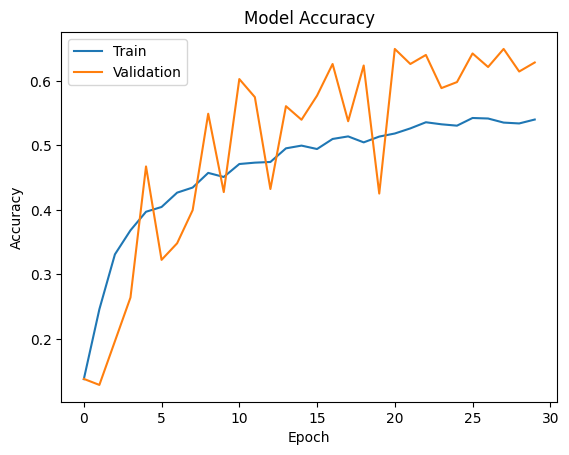

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [57]:
accuracy = model2.evaluate(X_test, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

15/15 - 0s - loss: 2285.5806 - accuracy: 0.1284 - 384ms/epoch - 26ms/step


**Plotting the Confusion Matrix**

In [59]:
# Complete the code to obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 5ms/step


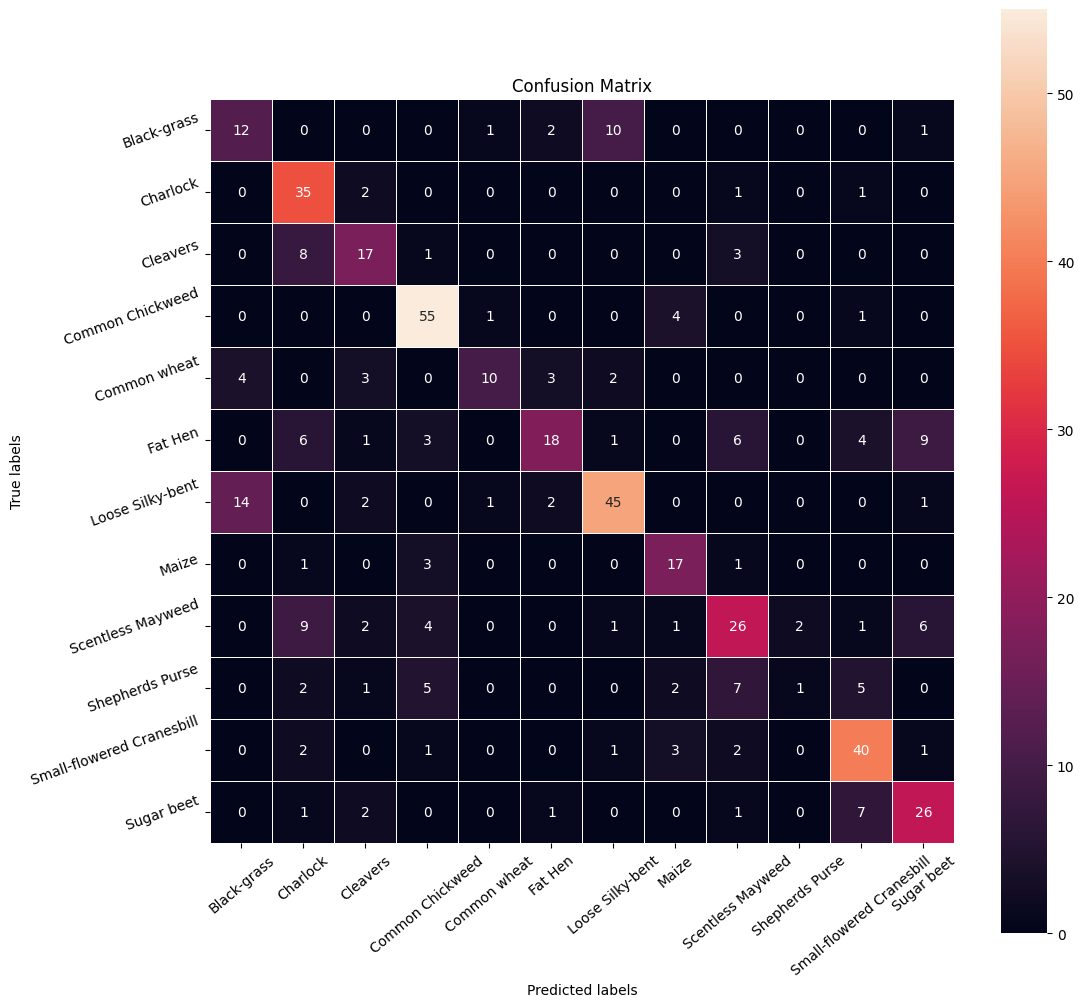

In [61]:
# Plotting the Confusion Matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Convert the TensorFlow EagerTensor to a NumPy array
confusion_matrix = confusion_matrix.numpy()

# Plotting the Confusion Matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(enc.classes_), rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_), rotation=20)
plt.show()


**Plotting Classification Report**

In [62]:
# Plotting the classification report
cr = classification_report(y_test_arg, y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.40      0.46      0.43        26
           1       0.55      0.90      0.68        39
           2       0.57      0.59      0.58        29
           3       0.76      0.90      0.83        61
           4       0.77      0.45      0.57        22
           5       0.69      0.38      0.49        48
           6       0.75      0.69      0.72        65
           7       0.63      0.77      0.69        22
           8       0.55      0.50      0.53        52
           9       0.33      0.04      0.08        23
          10       0.68      0.80      0.73        50
          11       0.59      0.68      0.63        38

    accuracy                           0.64       475
   macro avg       0.61      0.60      0.58       475
weighted avg       0.63      0.64      0.62       475



## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

### Visualizing the prediction

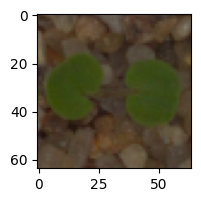

1/1 [==============================] - 0s 220ms/step
Predicted Label: Small-flowered Cranesbill
True Label: Small-flowered Cranesbill


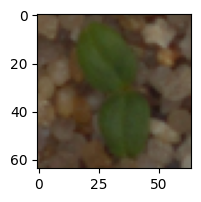

1/1 [==============================] - 0s 19ms/step
Predicted Label: Cleavers
True Label: Cleavers


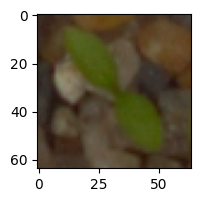

1/1 [==============================] - 0s 19ms/step
Predicted Label: Common Chickweed
True Label: Common Chickweed


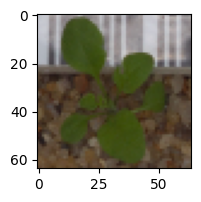

1/1 [==============================] - 0s 19ms/step
Predicted Label: Shepherds Purse
True Label: Shepherds Purse


In [63]:
# Visualizing the predicted and correct label of images from test data

# Example 1
plt.figure(figsize=(2, 2))
plt.imshow(X_test[2])
plt.show()

# Predicting the label using model1
predicted_label = enc.inverse_transform(model1.predict(X_test_normalized[2].reshape(1, 64, 64, 3)))
true_label = enc.inverse_transform(y_test_encoded)[2]

print('Predicted Label:', predicted_label[0])
print('True Label:', true_label)

# Example 2
plt.figure(figsize=(2, 2))
plt.imshow(X_test[33])
plt.show()

# Predicting the label using model1
predicted_label = enc.inverse_transform(model1.predict(X_test_normalized[33].reshape(1, 64, 64, 3)))
true_label = enc.inverse_transform(y_test_encoded)[33]

print('Predicted Label:', predicted_label[0])
print('True Label:', true_label)

# Example 3
plt.figure(figsize=(2, 2))
plt.imshow(X_test[59])
plt.show()

# Predicting the label using model1
predicted_label = enc.inverse_transform(model1.predict(X_test_normalized[59].reshape(1, 64, 64, 3)))
true_label = enc.inverse_transform(y_test_encoded)[59]

print('Predicted Label:', predicted_label[0])
print('True Label:', true_label)

# Example 4
plt.figure(figsize=(2, 2))
plt.imshow(X_test[36])
plt.show()

# Predicting the label using model1
predicted_label = enc.inverse_transform(model1.predict(X_test_normalized[36].reshape(1, 64, 64, 3)))
true_label = enc.inverse_transform(y_test_encoded)[36]

print('Predicted Label:', predicted_label[0])
print('True Label:', true_label)


## Actionable Insights and Business Recommendations

- The model1 without augumentation performs better than the model2 with augmentation

-This may be due to the following reasons:
  - Data Quality: The non-augmented dataset may have higher quality and cleaner images. In some cases, data augmentation might introduce noise or artifacts, particularly if the augmentation techniques are not carefully chosen or applied.
  - Overfitting: Data augmentation is primarily used to combat overfitting, where the model becomes too specialized in recognizing variations in the training data but struggles to generalize to unseen data. If the non-augmented dataset is sufficiently diverse and large, and the model architecture is well-suited to the task, it may not suffer from overfitting as much, making data augmentation less necessary.
  - Augmentation Strategy: The effectiveness of data augmentation depends on the choice of augmentation techniques and their parameters. If inappropriate or excessive augmentations are applied, they could harm the model's performance rather than improve it.
  - Domain Knowledge: Domain-specific knowledge can guide the decision of whether or not to use augmentation. Understanding the characteristics of the plant images and the challenges of the classification task can help determine the most appropriate data preprocessing strategies.


## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.


_____